In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

/Users/mwoods/Developer/open-ai-gym/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
env = gym.make('CartPole-v0')
path_to_recording = './tmp/CartPole-v0-gradient'


[2017-01-03 14:33:49,597] Making new env: CartPole-v0


In [14]:


def policy_gradient():
    
    """
    updates the policy gradient based on receiveing a state tensor and an action tensor 
    """
    state = tf.placeholder(dtype = tf.float32, shape = (None, 4))
    actions = tf.placeholder(dtype = tf.float32, shape  = (None, 2))
    advantage = tf.placeholder(dtype = tf.float32, shape  = (None, 1))
    
    linear_weights = tf.Variable(tf.zeros((4, 2)))
    linear = tf.matmul(state, linear_weights)
    est_probs = tf.nn.softmax(linear)
    
    acc = tf.reduce_sum(tf.mul(est_probs, actions), reduction_indices = [1])
    log_probs = tf.log(acc)
    loss = -tf.reduce_sum(log_probs * advantage)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    return optimizer, state, actions, advantage, est_probs, loss, linear_weights


def value_gradient():
    """
    a 2 layer Feed Forward Net to estimate the value as a function of the state vector
    """
    state = tf.placeholder(dtype=tf.float32, shape = (None, 4))
    val = tf.placeholder(dtype=tf.float32, shape = (None, 1))
    
    w1 = tf.Variable(tf.random_normal([4, 10]))
    b1 = tf.Variable(tf.zeros([10]))
    h1 = tf.nn.sigmoid(tf.matmul(state, w1) + b1)
    
    w2 = tf.Variable(tf.random_normal([10, 1]))
    b2 = tf.Variable(tf.zeros([1]))
    val_est = tf.matmul(h1, w2) + b2
    
    loss = tf.nn.l2_loss(val_est - val)
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)
    return optimizer, state, val, val_est, loss


In [15]:
policy_opt, policy_state_var, policy_action_var, policy_advantages_var,  policy_action_est, policy_loss, wts = policy_gradient()
value_opt, value_state_var, value_val_var, value_val_est, value_loss = value_gradient()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

TOTAL_NUMBER_OF_TRAINING_EPISODES = 0
GLOBAL_pol_loss_hist = []
GLOBAL_val_loss_hist = []
GLOBAL_reward_hist = []

In [16]:
num_episodes = 2500
gamma = 0.97

pol_loss_hist = []
val_loss_hist = []
reward_hist = []
mean_max_prob = []
 
print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES
for epoch in xrange(num_episodes):
    TOTAL_NUMBER_OF_TRAINING_EPISODES += 1
    obs = env.reset()
    states = []
    actions = []
    transitions = []
    total_reward = 0.0
    eps = 1.0/(epoch + 4.0)
    max_prob_per_step = []
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        #if np.random.rand() > probs.max():
        #    action = env.action_space.sample()
        #else:
        #    action = 0 if (probs[0][0] > 0.5) else 1
        #print probs
        #THIS EXPLORATION FUNCTION IS THE MOST CRITICAL PART TO THE SUCCESS of the model. WHY???
        
        action = 0 if np.random.rand() < probs[0][0] else 1 #intresting approach.. as you get more confident in your answers the model will start to scale down
        max_prob = probs.max()
        #print obs
        #print action, probs
        
        action_arr = np.zeros(2)
        action_arr[action] = 1.0

        next_obs, reward, done, _ = env.step(action)

        states.append(obs)
        actions.append(action_arr)
        transitions.append((next_obs, reward, done))

        total_reward += reward
        max_prob_per_step.append(max_prob)
        obs = next_obs
        if done or total_reward > 500:
            break
    
    
    future_rewards = []
    for idx, trans in enumerate(transitions):
        obs, rew, done = trans
        cum_reward = 0.0
        for idx2, future_trans in enumerate(transitions[idx:]):
            _, future_reward, _ = future_trans
            #print (gamma**idx2) * future_reward
            cum_reward += (gamma**idx2) * future_reward
        
        future_rewards.append([cum_reward])
    

    #calculate the difference between the true reward and the estimated value
    #if the policy suggests an action, but the true future reward is worse than the predicted result, then it will increase
    #the loss score, which will pull t he policy in the other direction
    N = len(states) #batch size
    obs_ = [obs for obs, _, _ in  transitions]
    estimated_val = sess.run(value_val_est, feed_dict = {value_state_var : obs_})
    future_rewards =  np.array(future_rewards)
    future_rewards = (future_rewards - future_rewards.mean())/future_rewards.std()
    
    advantage = (future_rewards - estimated_val)

    pol_opt, pol_loss = sess.run([policy_opt, policy_loss], feed_dict = {policy_state_var: states, 
                                                                         policy_action_var: actions,
                                                                         policy_advantages_var: advantage
                                                                        })
    
    val_opt, val_loss = sess.run([value_opt, value_loss], feed_dict = {value_state_var: states, value_val_var: future_rewards})
    
    #normalizing loss by batch size
    pol_loss_hist.append(pol_loss/N)
    val_loss_hist.append(val_loss/N)
    reward_hist.append(total_reward)
    mean_max_prob.append(np.array(max_prob_per_step).mean())
    if epoch % 10 == 0:
        print 'episode', epoch, 'total_reward', total_reward, pol_loss, val_loss, advantage.mean()
    
    #if sum(reward_hist[-100:])/100.0 > 250:
    #    break
        

print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES
GLOBAL_pol_loss_hist += pol_loss_hist
GLOBAL_val_loss_hist += val_loss_hist
GLOBAL_reward_hist += reward_hist


Total # of episodes trained so far 0
episode 0 total_reward 27.0 646.324 42.5714 1.27907643936
episode 10 total_reward 58.0 4440.89 130.465 1.92365810583
episode 20 total_reward 23.0 481.4 43.6548 1.29561992314
episode 30 total_reward 22.0 715.355 60.5012 2.22950889847
episode 40 total_reward 37.0 1227.0 64.9436 1.37318244496
episode 50 total_reward 13.0 326.915 37.8098 2.38631326419
episode 60 total_reward 15.0 382.821 42.29 2.32975051403
episode 70 total_reward 37.0 1834.38 92.0153 2.08783057896
episode 80 total_reward 13.0 116.669 17.3598 1.00848823327
episode 90 total_reward 38.0 1369.67 69.8731 1.42409455776
episode 100 total_reward 43.0 1518.28 60.7164 1.2600332249
episode 110 total_reward 18.0 453.961 44.1943 2.14188755883
episode 120 total_reward 23.0 717.54 51.5656 2.03807365894
episode 130 total_reward 66.0 5681.18 148.137 1.97910805182
episode 140 total_reward 29.0 1161.55 79.8906 2.159756792
episode 150 total_reward 65.0 4971.91 130.793 1.85826420967
episode 160 total_rewar

In [17]:

smoothed_pol_loss_hist = [sum(GLOBAL_pol_loss_hist[i-99:i])/100.0 for i in range(99, len(GLOBAL_pol_loss_hist)) ]

smoothed_val_loss_hist = [sum(GLOBAL_val_loss_hist[i-99:i])/100.0 for i in range(99, len(GLOBAL_val_loss_hist)) ]
smoothed_reward_hist = [sum(GLOBAL_reward_hist[i-99:i])/100.0 for i in range(99, len(GLOBAL_reward_hist)) ]
smoothed_mean_max_prob = [sum(mean_max_prob[i-99:i])/100.0 for i in range(99, len(mean_max_prob))]


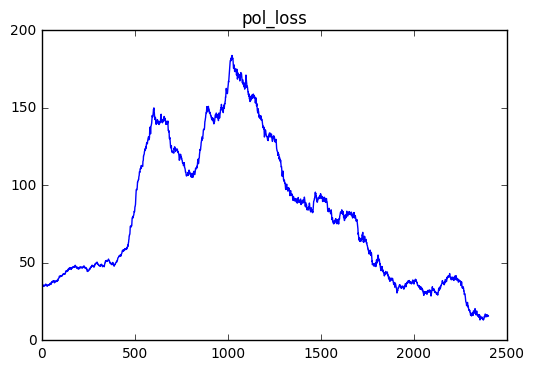

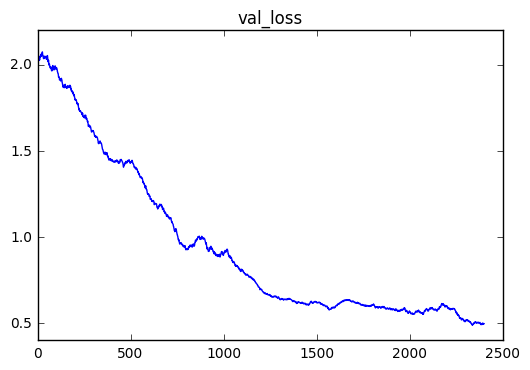

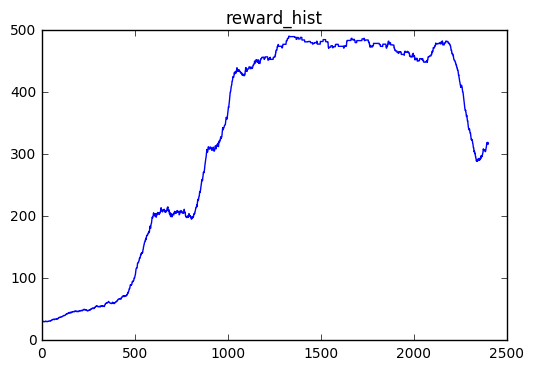

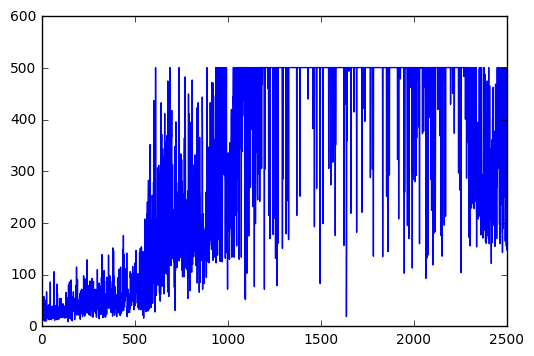

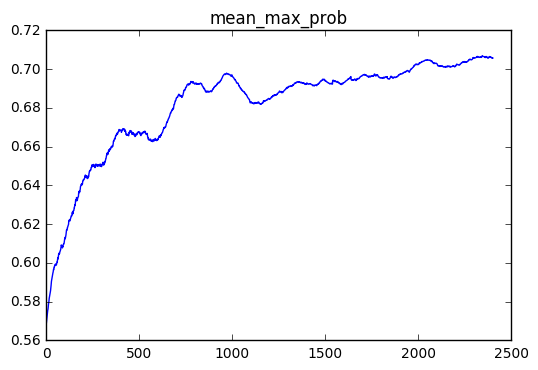

In [21]:


plt.plot(smoothed_pol_loss_hist)
plt.title("pol_loss")
plt.show()

plt.plot(smoothed_val_loss_hist)
plt.title("val_loss")
plt.show()

plt.plot(smoothed_reward_hist)
plt.title("reward_hist")
plt.show()

plt.plot(GLOBAL_reward_hist)
plt.show()

plt.plot(smoothed_mean_max_prob)
plt.title("mean_max_prob")
plt.show()



episode 0 reward 501.0
episode 25 reward 501.0
episode 50 reward 501.0
episode 75 reward 501.0
episode 100 reward 501.0
episode 125 reward 501.0
episode 150 reward 501.0
episode 175 reward 501.0
episode 200 reward 501.0


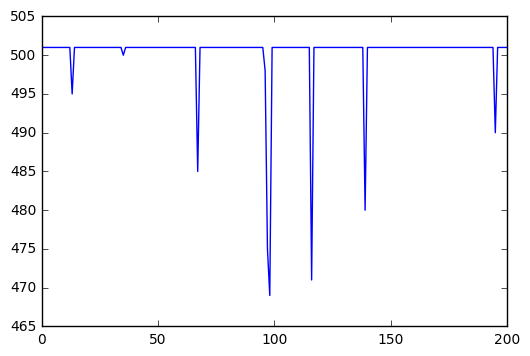

In [20]:
rewards = []
for i in xrange(201):
    obs = env.reset()
    total_reward = 0.0
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        action = 0 if 0.5 < probs[0][0] else 1
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if done or total_reward > 500:
            break
    rewards.append(total_reward)
    if i % 25 == 0:
        print 'episode', i, 'reward', total_reward

plt.plot(rewards)
plt.show()
        

In [10]:
sum(reward_hist[-100: ])/100.0


24.16

In [11]:
#env.monitor.close()